In [26]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [27]:
from keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from keras import backend, models, layers, optimizers
from keras.layers import Dense, Flatten

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import scipy

from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [28]:
# Construct the path to each desired file
base_path = "input/"

train_dir = base_path + "train/"
valid_dir = base_path + "valid/"
test_dir = base_path + "test/"

# Data will flow through this generator and will normalize
#train_datagen = ImageDataGenerator(rescale=1./255) Included later for the purpose of data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
from tensorflow.keras.applications import ResNet50V2

In [29]:
resnet_base = ResNet50V2(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224, 224, 3))

In [33]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest')

In [34]:
# Moves data from their respective directories to the model
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

valid_gen = train_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

Found 45980 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.


In [35]:
resnet_base.trainable = True

# Setting trainable layers within transfer learning base model
for layer in resnet_base.layers[:-5]:
  layer.trainable = False
for layer in resnet_base.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2481e3d640> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f2450369d60> False
<keras.layers.convolutional.Conv2D object at 0x7f24504e7970> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f245022f130> False
<keras.layers.pooling.MaxPooling2D object at 0x7f24501b0280> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f24501ec0a0> False
<keras.layers.core.activation.Activation object at 0x7f24501c66d0> False
<keras.layers.convolutional.Conv2D object at 0x7f24501cfbe0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f24501cfac0> False
<keras.layers.core.activation.Activation object at 0x7f24501df190> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f24501e3580> False
<keras.layers.convolutional.Conv2D object at 0x7f24501e3d60> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f24501e3dc0> Fals

In [ ]:
# Model Creation
inputs = Input(shape=(224,224,3))
resnet_conv = resnet_base(inputs)
flatten_1 = layers.Flatten()(resnet_conv)
drop_1 = Dropout(0.2)(flatten_1)
dense_1 = layers.Dense(1024, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(drop_1)
batch_1 = BatchNormalization()(dense_1)
dense_2 = layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(batch_1)
outputs = layers.Dense(315, activation='softmax')(dense_2)

In [ ]:
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    min_delta=0.001, 
    mode='max'
)

In [18]:
model_resnet = Model(inputs=inputs, outputs=outputs)

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model_resnet.fit(train_gen,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_gen,
                       validation_steps = 50,
                       callbacks=[custom_early_stopping])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

Epoch 1/100
100/100 [==============================] - 305s 2s/step - loss: 7.3199 - accuracy: 0.1420 - val_loss: 5.9708 - val_accuracy: 0.3150
Epoch 2/100
100/100 [==============================] - 176s 2s/step - loss: 5.5884 - accuracy: 0.3680 - val_loss: 4.7315 - val_accuracy: 0.4950
Epoch 3/100
100/100 [==============================] - 223s 2s/step - loss: 4.6823 - accuracy: 0.5230 - val_loss: 3.9766 - val_accuracy: 0.5990
Epoch 4/100
100/100 [==============================] - 228s 2s/step - loss: 4.0733 - accuracy: 0.6155 - val_loss: 3.5179 - val_accuracy: 0.7000
Epoch 5/100
100/100 [==============================] - 223s 2s/step - loss: 3.6850 - accuracy: 0.6930 - val_loss: 3.2748 - val_accuracy: 0.7580
Epoch 6/100
100/100 [==============================] - 202s 2s/step - loss: 3.4341 - accuracy: 0.7345 - val_loss: 3.0933 - val_accuracy: 0.7770
Epoch 7/100
100/100 [==============================] - 164s 2s/step - loss: 3.2097 - accuracy: 0.7740 - val_loss: 2.9123 - val_accuracy:

100/100 [==============================] - 301s 2s/step - loss: 1.4376 - accuracy: 0.9590 - val_loss: 1.5646 - val_accuracy: 0.9170
Epoch 58/100
100/100 [==============================] - 202s 2s/step - loss: 1.4198 - accuracy: 0.9590 - val_loss: 1.5432 - val_accuracy: 0.9110
Epoch 59/100
100/100 [==============================] - 334s 3s/step - loss: 1.4198 - accuracy: 0.9585 - val_loss: 1.5213 - val_accuracy: 0.9220
Epoch 60/100
100/100 [==============================] - 238s 2s/step - loss: 1.4224 - accuracy: 0.9550 - val_loss: 1.5471 - val_accuracy: 0.9100
Epoch 61/100
100/100 [==============================] - 227s 2s/step - loss: 1.4113 - accuracy: 0.9635 - val_loss: 1.5216 - val_accuracy: 0.9190
Epoch 62/100
100/100 [==============================] - 231s 2s/step - loss: 1.3821 - accuracy: 0.9640 - val_loss: 1.5067 - val_accuracy: 0.9310
Epoch 63/100
100/100 [==============================] - 164s 2s/step - loss: 1.3744 - accuracy: 0.9685 - val_loss: 1.4775 - val_accuracy: 0.930

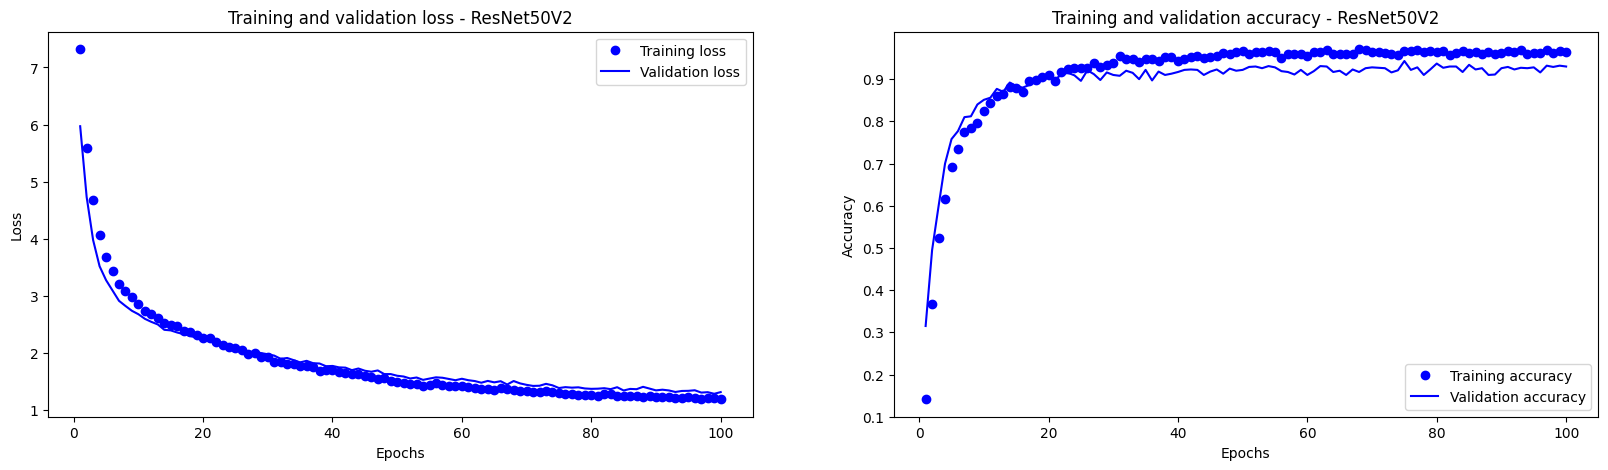

In [23]:
# Plotting Training accuracy vs Validation accuracy for comparison
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss - ResNet50V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy - ResNet50V2')
plt.xlabel('Epochs')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
resnet_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         